Project SHCT

Authors: Curumi Klejsi, Querzè Lorenzo  
Spring semester 2025

In [59]:
#import os
#os.chdir("/content/SHCT")
#import sys
#sys.path.append("/content/SHCT")
from pylab import *
import numpy as np
import Fluid_CP as FCP #calculation of  thermodynamic states
from scipy.optimize import minimize, NonlinearConstraint
from scipy.integrate import odeint
from scipy.optimize import bisect
import matplotlib.pyplot as plt
import pandas as pd

In [60]:
# PARAMETERS: 

working_time = 43200 # s, 12 hours in seconds

# Pasta

T_pasta_in = 7 # °C, initial pasta temperature 
T_pasta_fin = 85 # °C, final pasta temperature
m_pasta = 2 # kg, total kg of pasta
m_pasta_basket = 0.5 # kg of pasta per basket
t_break = 300 # s, break time in between batches
t_cook = 420 # s, cooking time for the pasta
R_h2o_pasta = 15 # K/kW, thermal resistance between pasta and water
cp_pasta = 3.5 # kJ/kg K, heat capacity of pasta

# H2O (sink)

T_sink_in = 20 # °C, initial water temperature in the morning
T_min_h2o = 85 # °C, minimum water temperature during operation
T_max_h2o = 93 # °C, maximum water temperature during operation
R_h2o_env = 30 # K/kW, thermal resistance between environment and water
cp_h2o = 4.18 # kJ/kg K, heat capacity of water
rho = 1/FCP.state(['T','p'],[T_max_h2o,1],fluid='water',Eh='CBar')['v'] # kg/m^3, density of water

# Air (source)

T_source = 20 # °C, heat source temperature, constant in cross-flow configuration

# Geometry of the pasta cooker:

h = 0.20 # m
w = 0.27 # m
l = 0.47 # m
V = h*w*l

# Heat duty to heat up the water from 85 to 93°C:

# Assumptions during modeling: 
# - 0D problem: no temperature gradient inside h2o and pasta
# - constant properties for water and pasta ---> therefore, thermal resistances and cps of pasta and water are constant

# Heat pump design:
# subcritical heat pump process
# techical constraints: superheating, subcooling, optimal COP, pinch points are respected...

TASK 1: simulate pasta cooking step

In [61]:
# REQUIRED THERMAL ENERGY INPUT TO COOK THE PASTA

#Q = m_pasta*cp_pasta*(T_pasta_fin - T_pasta_in)
#print('The required thermal energy input to cook pasta is: ', Q, ' kJ')
#Q_dot = Q/t_cook
#print('The required thermal power input to cook pasta is: ', Q_dot, ' kW')

Minimum heat-pump power  Q* = 5.03 kW


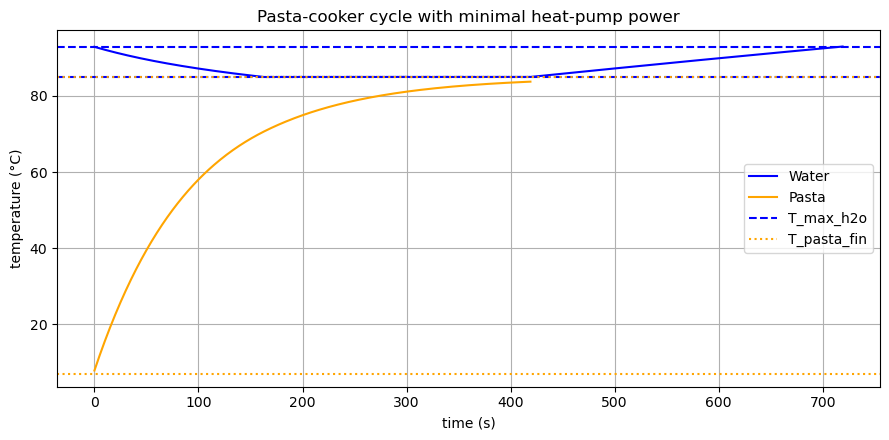

simulating 3 full cycles (0.6 h)


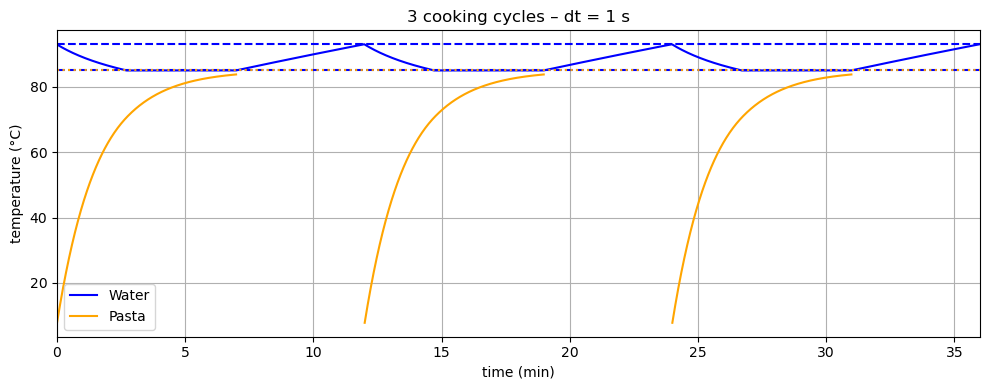

In [62]:
# Derived capacities
C_w = rho * V * cp_h2o          # kJ K⁻¹
C_p = m_pasta * cp_pasta        # kJ K⁻¹

# Integration set-up
dt       = 1.0                                  # s
steps_c  = int(t_cook  / dt)
steps_br = int(t_break / dt)

# ────────────────────────────────────────────────────────────────────────────
# Helper functions
# ────────────────────────────────────────────────────────────────────────────
def run_cycle(Q_hp):
    """Return Tp_end, Tw_after_break for a given pump power (kW)."""
    T_w = T_max_h2o
    T_p = T_pasta_in

    # ―― 7-min cooking phase ―――――――――――――――――――――――――――――――――――――――――
    for _ in range(steps_c):
        pump_on = T_w < T_min_h2o
        Q = Q_hp if pump_on else 0.0
        q_wp = (T_w - T_p) / R_h2o_pasta
        q_wa = (T_w - T_source) / R_h2o_env
        T_w += dt * (Q - q_wp - q_wa) / C_w
        T_p += dt *  q_wp / C_p

    # ―― 5-min reheating / idle phase (pump forced ON) ――――――――――――――――
    for _ in range(steps_br):
        q_wa = (T_w - T_source) / R_h2o_env
        T_w += dt * (Q_hp - q_wa) / C_w       # pasta is out

    return T_p, T_w


def residual(Q_hp):
    """Positive → requirements not met."""
    Tp_end, Tw_break = run_cycle(Q_hp)
    return max(Tp_end - T_pasta_fin,     # pasta too hot?
               T_max_h2o - Tw_break)     # bath still too cold?


# ────────────────────────────────────────────────────────────────────────────
# Find the minimum heat-pump power (kW)
# ────────────────────────────────────────────────────────────────────────────
Q_lo, Q_hi = 0.1, 20.0            # initial bracket
while residual(Q_hi) > 0:         # enlarge until feasible
    Q_hi *= 1.5

Q_star = bisect(residual, Q_lo, Q_hi, xtol=1e-3)
print(f"Minimum heat-pump power  Q* = {Q_star:.2f} kW")

# ────────────────────────────────────────────────────────────────────────────
# Trajectory for plotting
# ────────────────────────────────────────────────────────────────────────────
T_w_hist, T_p_hist = [], []
T_w, T_p = T_max_h2o, T_pasta_in

# 7-min cook
for _ in range(steps_c):
    pump_on = T_w < T_min_h2o
    Q = Q_star if pump_on else 0.0
    q_wp = (T_w - T_p) / R_h2o_pasta
    q_wa = (T_w - T_source) / R_h2o_env
    T_w += dt * (Q - q_wp - q_wa) / C_w
    T_p += dt *  q_wp / C_p
    T_w_hist.append(T_w)
    T_p_hist.append(T_p)

# 5-min break (pump ON)
for _ in range(steps_br):
    q_wa = (T_w - T_source) / R_h2o_env
    T_w += dt * (Q_star - q_wa) / C_w
    T_w_hist.append(T_w)
    T_p_hist.append(np.nan)       # pasta removed

# ────────────────────────────────────────────────────────────────────────────
# Plot
# ────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(9, 4.5))
plt.plot(T_w_hist, label='Water', color='blue')
plt.plot(T_p_hist, label='Pasta', color='orange')
plt.axhline(T_max_h2o,  ls='--', color='blue',   label='T_max_h2o')
plt.axhline(T_min_h2o,  ls='--', color='blue')
plt.axhline(T_pasta_fin, ls=':', color='orange', label='T_pasta_fin')
plt.axhline(T_pasta_in,  ls=':', color='orange')
plt.xlabel('time (s)')
plt.ylabel('temperature (°C)')
plt.title('Pasta-cooker cycle with minimal heat-pump power')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# 1. helper that returns the TW & TP trajectories for ONE cycle
#    (identical maths, but we now also return the whole trace)
# --------------------------------------------------------------------------
def one_cycle(Q_hp, T_w0):
    """Run a cook+break cycle starting at water temp T_w0.
       Returns      Tw_trace, Tp_trace, T_w_end
    """
    Tw, Tp = T_w0, T_pasta_in
    Tw_hist, Tp_hist = [], []

    # ➊ cook – pump ON only when Tw < 85 °C
    for _ in range(steps_c):
        pump_on = Tw < T_min_h2o
        Q = Q_hp if pump_on else 0.0
        q_wp = (Tw - Tp) / R_h2o_pasta
        q_wa = (Tw - T_source) / R_h2o_env
        Tw  += dt * (Q - q_wp - q_wa) / C_w
        Tp  += dt *  q_wp / C_p
        Tw_hist.append(Tw)
        Tp_hist.append(Tp)

    # ➋ break – pasta out, pump forced ON
    for _ in range(steps_br):
        q_wa = (Tw - T_source) / R_h2o_env
        Tw  += dt * (Q_hp - q_wa) / C_w
        Tw_hist.append(Tw)
        Tp_hist.append(np.nan)          # pasta absent

    return Tw_hist, Tp_hist, Tw        # final Tw is start of next cycle


# --------------------------------------------------------------------------
# 2. how many cycles in the 12-hour shift?
# --------------------------------------------------------------------------
t_cycle = t_cook + t_break
n_cycles = int(working_time / t_cycle)
n_cycles = 3
print(f"simulating {n_cycles} full cycles ({n_cycles*(t_cook+t_break)/3600:.1f} h)")

# --------------------------------------------------------------------------
# 3. simulate the whole day
# --------------------------------------------------------------------------
Q_star   = Q_star        # ← reuse the optimal power you already found
Tw_all, Tp_all           = [], []
Tw_start                  = T_max_h2o

for k in range(n_cycles):
    Tw_tr, Tp_tr, Tw_start = one_cycle(Q_star, Tw_start)
    Tw_all.extend(Tw_tr)
    Tp_all.extend(Tp_tr)

# build a matching time axis (seconds)
t_all = np.arange(len(Tw_all)) * dt

# --------------------------------------------------------------------------
# 4. plot
# --------------------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(t_all/60, Tw_all, label='Water', color='blue')
plt.plot(t_all/60, Tp_all, label='Pasta', color='orange')
plt.axhline(T_max_h2o,  ls='--', color='blue')
plt.axhline(T_min_h2o,  ls='--', color='blue')
plt.axhline(T_pasta_fin, ls=':', color='orange')
plt.xlabel('time (min)')
plt.ylabel('temperature (°C)')
plt.title(f'{n_cycles} cooking cycles – dt = {dt:.0f} s')
plt.xlim(0, n_cycles*(t_cook+t_break)/60)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [63]:
def model(y,t,Q):
    T_h2o, T_pasta = y
    Q_dot_env = (T_h2o - T_source) / R_h2o_env
    Q_dot_pasta = (T_h2o - T_pasta) / R_h2o_pasta
    if Q > 0:        
        dT_h2o_dt = (- Q_dot_pasta + Q) / (V * rho * cp_h2o) # - Q_dot_env - Q_dot_pasta
    else:
        dT_h2o_dt = (- Q_dot_env - Q_dot_pasta) / (V * rho * cp_h2o)
    dT_pasta_dt = (Q_dot_pasta) / (m_pasta * cp_pasta)

    return [dT_h2o_dt, dT_pasta_dt]

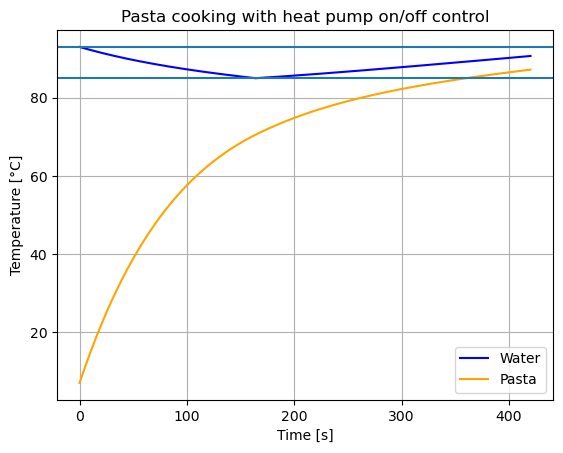

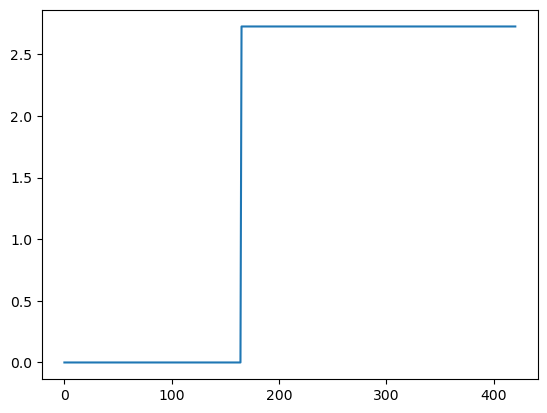

In [64]:
# Simulation setup

dt = 1
t_sim = np.arange(0, t_cook+dt, dt)
state = [T_max_h2o, T_pasta_in]  # [T_h2o, T_pasta]
T_h2o = [state[0]]
T_pasta = [state[1]]
Q_track = [0]
heat_pump = "off"
Q=0

# Time loop

for i in range(1, len(t_sim)):
    
    Tprev = state[0]

    # --- Controller Logic ---
    if Tprev <= T_min_h2o:
        if heat_pump == "off":
            heat_pump = "on"
            Q = Q_h2o        
    
    elif Tprev >= T_max_h2o:
        if heat_pump == "on":
            heat_pump = "off"
            Q = 0       
    
    elif T_min_h2o < Tprev < T_max_h2o:
        if heat_pump == "on":
            Q = Q_h2o
        else:
            Q = 0
    
    # Integrate one step
    state_next = odeint(model, state, [0, dt], args=(Q,))
    state = state_next[-1]  # update current state

    # Store
    T_h2o.append(state[0])
    T_pasta.append(state[1])
    Q_track.append(Q)
plt.plot(t_sim, T_h2o, label='Water', color='blue')
plt.plot(t_sim, T_pasta, label='Pasta', color='orange')
plt.axhline(T_max_h2o)
plt.axhline(T_min_h2o)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.grid(True)
plt.title("Pasta cooking with heat pump on/off control")
plt.show()
#print(T_h2o)
#print(T_pasta)
plt.plot(t_sim, Q_track)

In [65]:
print(state)

[90.6778675  87.18284498]


In [66]:
def h2o_energy_balance(x):
    T_in, T_fin = x
    rho = 1/FCP.state(['T','p'],[T_in,1],fluid='water',Eh='CBar')['v']
    T_water = np.linspace(T_in, T_fin, t_cook)
    T_pasta = np.linspace(T_pasta_in, T_pasta_fin, t_cook)
    Q = 0
    for t in range(0,t_cook):
        Q = Q + (T_water[t]-T_source)/R_h2o_env + (T_water[t]-T_pasta[t])/R_h2o_pasta
    return np.abs(rho*cp_h2o*V*(T_water[0] - T_water[-1]) - Q)

def h2o_constraint(x):
    T_in, T_fin = x
    return T_in - T_fin

In [67]:
t = linspace(0,t_cook, t_cook+1)
print(t)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [68]:
NC1 = NonlinearConstraint(h2o_constraint, 0, np.inf)
bounds = [(85,93),(85,93)]
x0 = [91,87]
res = minimize(h2o_energy_balance, x0, method='SLSQP', bounds=bounds, constraints=[NC1])
print(res.x)
print(res.fun)

[93. 85.]
1352.4656649158


In [69]:
def h2o_final_temperature(T):
    rho = 1/FCP.state(['T','p'],[T,1],fluid='water',Eh='CBar')['v']
    dt = 1 # timestep
    for i in t:
        

SyntaxError: incomplete input (2238364486.py, line 5)